<a href="https://colab.research.google.com/github/dkomlen/finance-ml/blob/main/case%20study%203%20-%20fraud%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# XGBoost
from xgboost import XGBClassifier

In [4]:
dataset = pd.read_csv('https://raw.githubusercontent.com/tatsath/fin-ml/master/Chapter%206%20-%20Sup.%20Learning%20-%20Classification%20models/CaseStudy1%20-%20Fraud%20Detection/creditcard_sample.csv')

In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### Exploratory data analysis

#### Descriptive statistics

In [6]:
dataset.shape

(99999, 31)

In [7]:
pd.set_option('precision', 3)
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.62,0
1,0,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.69,0
2,1,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.66,0
3,1,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.50,0
4,2,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.99,0


In [8]:
dataset.dtypes

Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [9]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,...,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,1.000e+05,99999.000,99999.000,99999.000
mean,42432.982,-0.262,-0.032,0.676,0.163,-0.279,0.094,-0.109,0.056,-0.047,...,-0.031,-0.109,-0.037,0.009,0.132,0.027,6.058e-04,0.002,97.962,0.002
std,17044.825,1.859,1.657,1.323,1.349,1.356,1.301,1.211,1.208,1.121,...,0.719,0.634,0.633,0.595,0.441,0.495,3.937e-01,0.325,264.624,0.047
min,0.000,-56.408,-72.716,-33.681,-5.173,-42.148,-26.161,-31.765,-73.217,-9.284,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.534,-9.391e+00,-9.618,0.000,0.000
25%,33471.500,-1.028,-0.599,0.177,-0.711,-0.899,-0.648,-0.600,-0.137,-0.699,...,-0.225,-0.531,-0.176,-0.324,-0.132,-0.325,-6.253e-02,-0.005,7.570,0.000
50%,44299.000,-0.261,0.078,0.754,0.193,-0.314,-0.157,-0.069,0.074,-0.119,...,-0.058,-0.084,-0.049,0.065,0.170,-0.070,9.832e-03,0.023,26.310,0.000
75%,55851.000,1.153,0.736,1.376,1.032,0.250,0.486,0.415,0.361,0.558,...,0.119,0.308,0.082,0.406,0.420,0.301,8.302e-02,0.077,89.000,0.000
max,67374.000,1.960,18.902,4.226,16.716,34.802,22.529,36.677,20.007,10.393,...,22.615,10.503,19.003,4.014,5.542,3.517,1.215e+01,33.848,19656.530,1.000


In [10]:
dataset['Class'].value_counts().rename(index = {0: 'Not Fraud', 1: 'Fraud'})

Not Fraud    99776
Fraud          223
Name: Class, dtype: int64

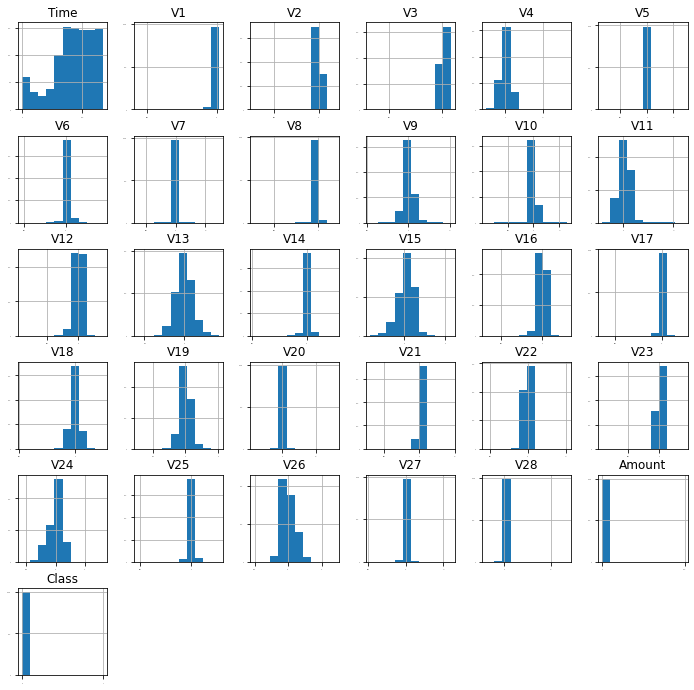

In [11]:
dataset.hist(xlabelsize=1, ylabelsize=1, figsize=(12,12));

In [12]:
dataset.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### 4.2 Feature selection

In [13]:
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(k=10)
Y = dataset.iloc[:,-1]
X = dataset.iloc[:,:-1]
fit = bestfeatures.fit(X,Y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score') #print 10 best features

,Specs,Score
17,V17,20657.815
14,V14,16227.609
3,V3,10383.969
12,V12,9644.180
10,V10,7909.706
16,V16,6829.653
7,V7,6157.564
11,V11,3567.597
4,V4,2840.800
18,V18,2632.037


### 5. Evaluate Algorithms and Models

#### 5.1 Train Test Split 

In [14]:
validation_size = 0.2
seed = 7

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, shuffle=True)

#### 5.2 Checking Models and Algorithms

In [17]:
num_folds = 3
scoring='accuracy'

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('XGB', XGBClassifier()))

In [18]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998587 (0.000047)
LDA: 0.998975 (0.000276)
KNN: 0.997850 (0.000365)
CART: 0.999100 (0.000170)
XGB: 0.999575 (0.000151)


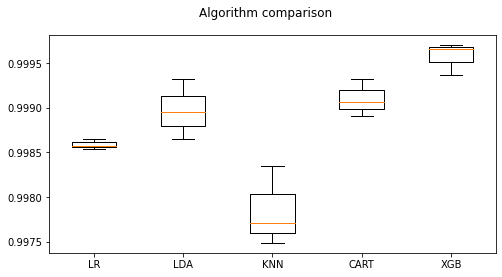

In [27]:
fig = pyplot.figure(figsize=(8,4))
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [28]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [31]:
predictions = model.predict(X_validation)
print('Accuracy:', accuracy_score(Y_validation, predictions))
print('Confusion matrix:\n', confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 0.9991
Confusion matrix:
 [[19947     5]
 [   13    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19952
           1       0.88      0.73      0.80        48

    accuracy                           1.00     20000
   macro avg       0.94      0.86      0.90     20000
weighted avg       1.00      1.00      1.00     20000



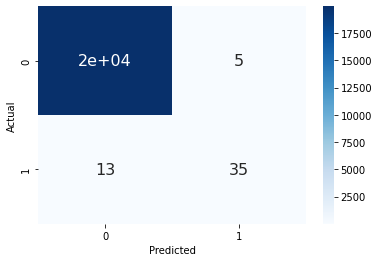

In [34]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [35]:
Y_validation.value_counts().rename(index = {0: 'Not Fraud', 1: 'Fraud'})

Not Fraud    19952
Fraud           48
Name: Class, dtype: int64

### 6. Model Tuning

#### 6.1 Model Tuning by choosing correct evaluation metric

In [37]:
scoring = 'recall'

In [40]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.571734 (0.084270)
LDA: 0.701518 (0.131230)
KNN: 0.019395 (0.018057)
CART: 0.778629 (0.021932)
XGB: 0.847299 (0.031202)


In [42]:
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier()

In [43]:
predictions = model.predict(X_validation)
print('Accuracy:', accuracy_score(Y_validation, predictions))
print('Confusion matrix:\n', confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 0.9994
Confusion matrix:
 [[19950     2]
 [   10    38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19952
           1       0.95      0.79      0.86        48

    accuracy                           1.00     20000
   macro avg       0.97      0.90      0.93     20000
weighted avg       1.00      1.00      1.00     20000



### 6.2 Model Tuning for balancing the sample by Random Under Sampling

In [50]:
Y_train.value_counts().rename(index = {0: 'Not Fraud', 1: 'Fraud'})

Not Fraud    79824
Fraud          175
Name: Class, dtype: int64

In [60]:
df = pd.concat([X_train, Y_train], axis=1)
# amount of fraud classes 175 rows.
fraud_df = df.loc[df['Class']==1]
non_fraud_df = df.loc[df['Class']==0][:175]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

df_new = normal_distributed_df.sample(frac=1, random_state=42)
Y_train_new = df_new['Class']
X_train_new = df_new.loc[:, dataset.columns != 'Class']

1    175
0    175
Name: Class, dtype: int64

In [62]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('XGB', XGBClassifier()))

In [69]:
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_new, Y_train_new, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.930973 (0.016062)
LDA: 0.867897 (0.024909)
KNN: 0.623345 (0.045482)
CART: 0.925626 (0.021207)
NB: 0.873453 (0.032232)
SVM: 0.452939 (0.055019)
NN: 0.768254 (0.316027)
AB: 0.948433 (0.014141)
GBM: 0.931275 (0.014313)
RF: 0.930973 (0.016062)
ET: 0.925323 (0.017548)
XGB: 0.942575 (0.009908)


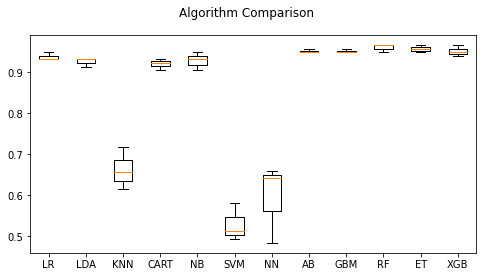

In [68]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

In [66]:
scoring

'recall'